In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
# Root data path
data_path = 'dataset/'

In [61]:
# Transform
data_transforms = {
    'train':
        transforms.Compose([
            transforms.ToTensor(),
            # from Preprocess file result
            transforms.Normalize([0.4388, 0.4213, 0.4016], [0.2508, 0.2558, 0.2859])
        ]),
    'val':
        transforms.Compose([
            transforms.ToTensor(),
            # from Preprocess file result
            transforms.Normalize([0.4388, 0.4213, 0.4016], [0.2508, 0.2558, 0.2859])
        ]),
}

In [11]:
# Data load and basic info
# Data load
image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x),data_transforms[x])
                  for x in ['train', 'val']}

# Into dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# basic info
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)
print(dataset_sizes)
print(device)

['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'stained_glass', 'vault']
{'train': 8101, 'val': 2029}
cpu


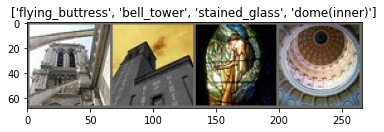

In [63]:
# image show function for visualization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4388, 0.4213, 0.4016])
    std = np.array([0.2508, 0.2558, 0.2859])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch (size 4 set in dataloader)
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [59]:
# Train function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
# Finetuning the ConvNet
# Pretrained image Residual ConvNet 18 layers
model_ft = models.resnet18(pretrained=True)

# Check output neuron number
num_ftrs = model_ft.fc.in_features

# fully connected output layer
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# Loss function setting
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
train Loss: 1.2190 Acc: 0.6334
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
val Loss: 0.7250 Acc: 0.8107

Epoch 1/24
----------
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
train Loss: 0.7223 Acc: 0.7782
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
val Loss: 0.4634 Acc: 0.8679

Epoch 2/24
----------
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
train Loss: 0.5237 Acc: 0.8362
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
val Loss: 0.3845 Acc: 0.8881

Epoch 3/24
----------
0.0
1.0
2

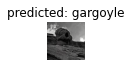

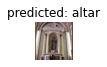

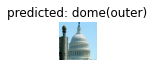

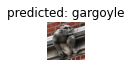

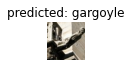

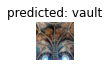

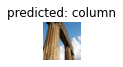

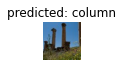

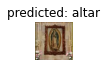

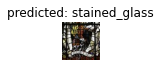

In [65]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_no = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_no += 1
                ax = plt.subplot(num_images//2, 2, images_no)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_no == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
visualize_model(model_ft)

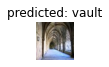

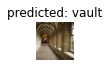

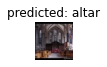

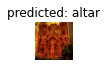

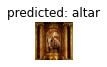

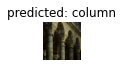

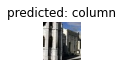

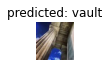

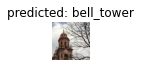

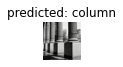

In [60]:
# Save Model
# Weights save (needs reinstruct model)
torch.save(model_ft.state_dict(), 'model.pth')

# Entire Model (needs directory structure)
torch.save(model_ft, 'model.pt')